In [1]:
import requests
import pandas as pd
from datetime import datetime

In [2]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from wordcloud import WordCloud
import geopandas as gpd
import folium

In [3]:
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# mongo
import pymongo
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

In [5]:
# mysql
import mysql.connector
from sqlalchemy import create_engine

In [3]:
# cassandra
from cassandra.cluster import Cluster
import uuid

In [7]:
# pyspark
import findspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import split, max as spark_max

In [2]:
from IPython.display import Image, display, HTML, clear_output
from base64 import b64encode, b64decode
from PIL import Image
import io

# EONET: Insert data to Mongo database

In [31]:
uri = "your_uri"

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Define the EONET API endpoint
eonet_url = 'https://eonet.gsfc.nasa.gov/api/v3/events'

database = client["Nasa_EONET"]
collection = database["natural_events"]

# Make a request to the EONET API
response = requests.get(eonet_url)

if response.status_code == 200:
    data = response.json()
    # Insert the retrieved data into MongoDB
    collection.insert_many(data['events'])
    print('Data inserted into MongoDB successfully.')
else:
    print('Failed to retrieve data from EONET API.')

Data inserted into MongoDB successfully.


# EONET: Fetch data from MongoDB using PySpark

In [9]:
findspark.init()

In [10]:
spark = SparkSession.builder \
    .appName("MongoDBSparkExample") \
    .config("spark.mongodb.input.uri", uri) \
    .config("spark.mongodb.input.database", database) \
    .config("spark.mongodb.input.collection", collection) \
    .getOrCreate()

In [11]:
spark

In [12]:
df = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option("spark.mongodb.input.uri", uri) \
    .option("spark.mongodb.input.database", "Nasa_EONET") \
    .option("spark.mongodb.input.collection", "natural_events").load()

In [13]:
client.close()

In [14]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- title: string (nullable = true)
 |-- closed: void (nullable = true)
 |-- description: string (nullable = true)
 |-- geometry: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- magnitudeValue: double (nullable = true)
 |    |    |-- magnitudeUnit: string (nullable = true)
 |    |    |-- date: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: double (containsNull = true)
 |-- id: string (nullable = true)
 |-- link: string (nullable = true)
 |-- sources: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- url: string (nullable = true)
 |-- title: stri

# EONET: manipulation using PySpark

In [15]:
# explode nested columns
df = df.withColumn('categories', f.explode('categories'))\
    .withColumn('Category ID', f.col('categories').getItem('id'))\
    .withColumn('Category Title', f.col('categories').getItem('title'))

In [16]:
df = df.withColumn('geometry', f.explode('geometry'))\
    .withColumn('Magnitude Value', f.col('geometry').getItem('magnitudeValue'))\
    .withColumn('Magnitude Unit', f.col('geometry').getItem('magnitudeUnit'))\
    .withColumn('Geometry Date', f.col('geometry').getItem('date'))\
    .withColumn('Geometry Type', f.col('geometry').getItem('type'))\
    .withColumn('Geometry Coordinates', f.col('geometry').getItem('coordinates'))

In [17]:
df = df.withColumn('sources', f.explode('sources'))\
    .withColumn('Source ID', f.col('sources').getItem('id'))\
    .withColumn('Source URL', f.col('sources').getItem('url'))

In [18]:
# remove unnecessary tables
df = df.drop('categories', 'geometry', 'sources', 'description', 'closed')

In [19]:
# split data into two columns
df = df.withColumn('Date', split(df['Geometry Date'], 'T').getItem(0)) \
       .withColumn('Time', split(df['Geometry Date'], 'T').getItem(1)) 

In [20]:
df = df.withColumn('Longitude', df['Geometry Coordinates'][0]) \
        .withColumn('Latitude', df['Geometry Coordinates'][1])

In [21]:
# remove unnecessary tables
df = df.drop('Geometry Date', 'Geometry Coordinates')

In [22]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- id: string (nullable = true)
 |-- link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- Category ID: string (nullable = true)
 |-- Category Title: string (nullable = true)
 |-- Magnitude Value: double (nullable = true)
 |-- Magnitude Unit: string (nullable = true)
 |-- Geometry Type: string (nullable = true)
 |-- Source ID: string (nullable = true)
 |-- Source URL: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)



In [23]:
# convert PySpark DF to Pandas DF
eonet_df = df.toPandas()

In [24]:
spark.stop()

In [42]:
# Removing duplicate events due to several Source ID for one event (based on coordinates)
eonet = eonet_df.drop_duplicates(subset=["Longitude", "Latitude"])
eonet.head()

,_id,id,link,title,Category ID,Category Title,Magnitude Value,Magnitude Unit,Geometry Type,Source ID,Source URL,Date,Time,Longitude,Latitude
0,"(64ff3d485e8c540f030c3afa,)",EONET_6423,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg D33A,seaLakeIce,Sea and Lake Ice,340.0,NM^2,Point,NATICE,https://usicecenter.gov/pub/Iceberg_Tabular.csv,2023-09-08,00:00:00Z,17.14,-69.38
1,"(64ff3d485e8c540f030c3afb,)",EONET_6424,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg D33B,seaLakeIce,Sea and Lake Ice,252.0,NM^2,Point,NATICE,https://usicecenter.gov/pub/Iceberg_Tabular.csv,2023-09-08,00:00:00Z,18.30,-69.64
2,"(64ff3d485e8c540f030c3afc,)",EONET_6421,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Tropical Storm Margot,severeStorms,Severe Storms,35.0,kts,Point,GDACS,http://www.gdacs.org/report.aspx?eventid=10010...,2023-09-07,21:00:00Z,-28.30,16.80
4,"(64ff3d485e8c540f030c3afc,)",EONET_6421,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Tropical Storm Margot,severeStorms,Severe Storms,35.0,kts,Point,GDACS,http://www.gdacs.org/report.aspx?eventid=10010...,2023-09-08,03:00:00Z,-29.30,16.80
6,"(64ff3d485e8c540f030c3afc,)",EONET_6421,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Tropical Storm Margot,severeStorms,Severe Storms,35.0,kts,Point,GDACS,http://www.gdacs.org/report.aspx?eventid=10010...,2023-09-08,09:00:00Z,-30.80,17.40


In [ ]:
# this cell need to be deleted at the end

In [6]:
#eonet = pd.read_csv("C:\\Ieva\\Python_Bootcamp\\Final_project_test_data\\eonet_data_Final.csv")
eonet = pd.read_csv("eonet_data.csv")
eonet.head()

,_id,id,link,title,Category ID,Category Title,Magnitude Value,Magnitude Unit,Geometry Type,Source ID,Source URL,Date,Time,Longitude,Latitude
0,Row(oid='6506a0255457d4ab94009af1'),EONET_6425,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,"Kilauea Volcano, Hawaii",volcanoes,Volcanoes,NaN,NaN,Point,SIVolcano,https://volcano.si.edu/volcano.cfm?vn=332010,2023-09-10,00:00:00Z,-155.287,19.421
1,Row(oid='6506a0255457d4ab94009af2'),EONET_6423,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg D33A,seaLakeIce,Sea and Lake Ice,340.0,NM^2,Point,NATICE,https://usicecenter.gov/pub/Iceberg_Tabular.csv,2023-09-08,00:00:00Z,17.140,-69.380
2,Row(oid='6506a0255457d4ab94009af2'),EONET_6423,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg D33A,seaLakeIce,Sea and Lake Ice,340.0,NM^2,Point,NATICE,https://usicecenter.gov/pub/Iceberg_Tabular.csv,2023-09-15,00:00:00Z,14.370,-69.230
3,Row(oid='6506a0255457d4ab94009af3'),EONET_6424,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg D33B,seaLakeIce,Sea and Lake Ice,252.0,NM^2,Point,NATICE,https://usicecenter.gov/pub/Iceberg_Tabular.csv,2023-09-08,00:00:00Z,18.300,-69.640
4,Row(oid='6506a0255457d4ab94009af3'),EONET_6424,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg D33B,seaLakeIce,Sea and Lake Ice,252.0,NM^2,Point,NATICE,https://usicecenter.gov/pub/Iceberg_Tabular.csv,2023-09-15,00:00:00Z,16.600,-69.450


# Meteorite Landings: insert data into Mysql database

In [43]:
response = requests.get("https://data.nasa.gov/resource/gh4g-9sfh.json")
data = response.json()

In [44]:
# Used to make df from response data
df = pd.DataFrame(data)
df.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,geolocation,:@computed_region_cbhk_fwbd,:@computed_region_nnqa_25f4
0,Aachen,1,Valid,L5,21,Fell,1880-01-01T00:00:00.000,50.775000,6.083330,"{'latitude': '50.775', 'longitude': '6.08333'}",NaN,NaN
1,Aarhus,2,Valid,H6,720,Fell,1951-01-01T00:00:00.000,56.183330,10.233330,"{'latitude': '56.18333', 'longitude': '10.23333'}",NaN,NaN
2,Abee,6,Valid,EH4,107000,Fell,1952-01-01T00:00:00.000,54.216670,-113.000000,"{'latitude': '54.21667', 'longitude': '-113.0'}",NaN,NaN
3,Acapulco,10,Valid,Acapulcoite,1914,Fell,1976-01-01T00:00:00.000,16.883330,-99.900000,"{'latitude': '16.88333', 'longitude': '-99.9'}",NaN,NaN
4,Achiras,370,Valid,L6,780,Fell,1902-01-01T00:00:00.000,-33.166670,-64.950000,"{'latitude': '-33.16667', 'longitude': '-64.95'}",NaN,NaN


In [ ]:
# 1 cell down need to be deleted at the end

In [7]:
# Important - this line at the end should be deleted! csv
meteor = pd.read_csv("Meteorite_Landings.csv")

In [45]:
# Function for changing date format, used for response
import re
def date_reformat(date):
    pattern = r'^(\d{4})'
    match = re.search(pattern, date)
    if match:
        return match.group(1)
    else:
        return None

df['year'] = df['year'].astype('str')   
df['year'] = df['year'].apply(date_reformat)

In [46]:
# Used for response
df = df.drop(["geolocation", ":@computed_region_nnqa_25f4", ":@computed_region_cbhk_fwbd"], axis=1)

In [47]:
# Used for response: important to do this before putting to mysql so that we would be able to do analysis in mysql (if we wanted)
df['id'] = df['id'].astype('int')
df['mass'] = df['mass'].astype('float')
df['year'] = df['year'].astype('float')
df['reclat'] = df['reclat'].astype('float')
df['reclong'] = df['reclong'].astype('float')

In [ ]:
# Used for csv file
df = df.drop("GeoLocation", axis = 1)

In [ ]:
conn = mysql.connector.connect(host='localhost',
                                    database= "sgtbootfinal",
                                    user='root',
                                    password='')

In [ ]:
engine = create_engine('mysql+mysqlconnector://root:@localhost/sgtbootfinal')

In [ ]:
# Entries must be uploaded in chunks. The db is too big to put everything in once

# Set the chunk size
chunk_size = 1000

# Iterate over chunks
for i in range(0, len(df), chunk_size):
    chunk = df.iloc[i:i+chunk_size]
    chunk.to_sql(name='meteorite_landings', con=engine, if_exists='append', index=False)

In [ ]:
cursor = conn.cursor()

primary_key_sql = """
ALTER TABLE meteorite_landings
ADD PRIMARY KEY (id);
"""

cursor.execute(primary_key_sql)

conn.commit()

In [ ]:
cursor.close()
conn.close()

# Meteorite Landings: Fetch data from Mysql using Pyspark

In [4]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("MySQLmeteorites") \
    .getOrCreate()

# Define database connection properties
db_properties = {
    "user": "root",
    "password": "",
    "driver": "com.mysql.cj.jdbc.Driver",
    "url": "jdbc:mysql://localhost:3306/sgtbootfinal"
}

In [5]:
# Specify the table to read from
table_name = "meteorite_landings"

# Read data from MySQL database into a PySpark DataFrame
df = spark.read.jdbc(url=db_properties["url"],
                     table=table_name,
                     properties=db_properties)

In [ ]:
# delete 1 cell after this one

In [14]:
# delete this cell later
engine = create_engine('mysql+mysqlconnector://root:@localhost/sgtbootfinal')
query = ("SELECT * FROM meteorite_landings")
meteor = pd.read_sql(query, engine)
meteor = meteor[meteor['reclong'] < 180.0]

In [6]:
# Data manipulations:
df = df[df['reclong'] < 180.0] # filtering out longitudes so that they would be less than 180

In [12]:
max_reclong = df.agg(spark_max("reclong")).collect()[0][0]
max_reclong

178.2

In [13]:
# PySpark DF convert to Pandas DF
meteor = df.toPandas()
meteor.head()

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abajo,4,Valid,H5,331.0,Found,1982.0,26.80000,-105.41667,"(26.8, -105.41667)"
3,Abbott,5,Valid,H3-6,21100.0,Found,1951.0,36.30000,-104.28333,"(36.3, -104.28333)"
4,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)"


In [16]:
# Stop the Spark session
spark.stop()

# NASA images: fetch the images using EONET titles and Meteorites names

In [12]:
# select TOP 500 heaviest meteorites
meteor = meteor.sort_values(by="mass (g)", ascending=False)
heavy_meteor = meteor.head(500)

In [13]:
# creata a dictionary with keywords and url for searching images
def create_urls_for_titles(df, column_name):
    urls_dict = dict()
    unique_values = df[column_name].unique()
    base_url = "https://images-api.nasa.gov/search?q="  
    for title in unique_values:
        # Build the URL for each title/ name
        title_url = base_url + title.replace('-', ' ').replace(" ", "-").replace(',', '-').replace('(', '-').replace(')', '-') + "&media_type=image"
        # Add the titles and its URL to the dictionary
        urls_dict[title] = title_url
    return urls_dict

column_name = 'name'
urls_dict = create_urls_for_titles(heavy_meteor, column_name)

In [14]:
# Create lists to store the keywords and first image URLs
keys = []
first_image_urls = []

# Iterate through the dictionary items
for key, value in urls_dict.items():
    try:
        # Send an HTTP GET request to the API
        response = requests.get(value)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Parse the JSON response
            data = response.json()

            # Extract the first image URL from the "preview" link if it exists
            if "collection" in data and "items" in data["collection"]:
                items = data["collection"]["items"]
                if items:
                    first_item = items[0]
                    if "links" in first_item:
                        links = first_item["links"]
                        for link in links:
                            if "href" in link and link["rel"] == "preview":
                                first_image_url = link["href"]
                                break
                    else:
                        first_image_url = None
                else:
                    first_image_url = None
            else:
                first_image_url = None

            # Check if there is a valid image URL
            if first_image_url:
                # Append the key and first image URL to the lists
                keys.append(key)
                first_image_urls.append(first_image_url)

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {key}: {e}")

In [10]:
# Create a Eonet image DataFrame from the lists
eonet_img = pd.DataFrame({'title': keys, 'url': first_image_urls})

In [15]:
# Create a TOP 500 heaviest meteorites images DataFrame from the lists after reruning code using meteor DF
meteor_img = pd.DataFrame({'title': keys, 'url': first_image_urls})

In [16]:
# concatenate two DF to new one
all_img = pd.concat([eonet_img, meteor_img], ignore_index=True)

In [17]:
# remove duplicated URLS
all_img = all_img.drop_duplicates(subset=['url'])

In [18]:
# Function to extract image content and add it as a separate column
def extract_image_content(df):
    image_content_column = []

    for url in df['url']:
        try:
            response = requests.get(url)
            if response.status_code == 200:
                # Convert the image content to a PIL Image object
                image = Image.open(io.BytesIO(response.content))
                
                # Append the image content to the image_content_column
                image_content_column.append(image)
            else:
                # Append None if the request was not successful
                image_content_column.append(None)
        except Exception as e:
            print(f"Error processing URL {url}: {e}")
            image_content_column.append(None)

    df['image_content'] = image_content_column

# Call the function to extract image content and add it as a separate column
extract_image_content(all_img)

# NASA images: Create Cassandra DB and insert images

In [51]:
# connect to Cassandra DB using command 'sudo service cassandra start' in ubuntu
cluster = Cluster(["127.0.0.1"],port=9042)
session = cluster.connect()

In [21]:
create_keyspace = """
    CREATE KEYSPACE nasa_project
    WITH replication = {'class': 'SimpleStrategy', 'replication_factor': 1};
"""

session.execute(create_keyspace)

In [52]:
session.execute("USE nasa_project")

In [25]:
uuid.uuid4()

UUID('9e97cb38-5a70-4890-9c83-d42886962fc7')

In [26]:
session.execute(""" 
CREATE TABLE nasa_images (
    id UUID PRIMARY KEY,
    title TEXT,
    url TEXT,
    image_content BLOB)
    """);

In [28]:
# Define a prepared INSERT statement
insert_statement = session.prepare("""
    INSERT INTO nasa_images (id, title, url, image_content)
    VALUES (?, ?, ?, ?)
""")

# Iterate over DataFrame rows and insert data into Cassandra
for _, row in all_img.iterrows():
    id = uuid.uuid4()  # Generate a UUID for the id field
    image = row['image_content']
    image_bytes = io.BytesIO()
    image.save(image_bytes, format='JPEG')
    image_data = image_bytes.getvalue()
    session.execute(insert_statement, (id, row['title'], row['url'], image_data))

In [53]:
result = session.execute("""SELECT title, url FROM nasa_images LIMIT 10""")
for row in result:
    print(row.title, row.url)

Knowles https://images-assets.nasa.gov/image/SSC-20120420-S00534P/SSC-20120420-S00534P~thumb.jpg
Bagana Volcano, Papua New Guinea https://images-assets.nasa.gov/image/iss068e007429/iss068e007429~thumb.jpg
Cook 001 https://images-assets.nasa.gov/image/iss029-s-001/iss029-s-001~thumb.jpg
Camp Wood https://images-assets.nasa.gov/image/iss015e08920/iss015e08920~thumb.jpg
Weston https://images-assets.nasa.gov/image/ARC-2008-ACD08-0202-001/ARC-2008-ACD08-0202-001~thumb.jpg
Ainsworth https://images-assets.nasa.gov/image/LRC-2014-00077/LRC-2014-00077~thumb.jpg
Navajo https://images-assets.nasa.gov/image/iss012e05172/iss012e05172~thumb.jpg
Trenton https://images-assets.nasa.gov/image/GSFC_20171208_Archive_e000811/GSFC_20171208_Archive_e000811~thumb.jpg
Jenkins https://images-assets.nasa.gov/image/PIA00981/PIA00981~thumb.jpg
Gretna https://images-assets.nasa.gov/image/iss067e184608/iss067e184608~thumb.jpg


# NASA images: Display the image from Cassandra DB

In [48]:
title = 'Red Fire'
query = f"SELECT image_content FROM nasa_images WHERE title = '{title}' ALLOW FILTERING"
rows = session.execute(query)

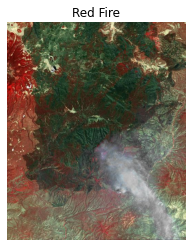

In [49]:
# Get the image content from the result
image_content = rows.one().image_content

# Convert the image content bytes to a PIL Image object
image = Image.open(io.BytesIO(image_content))

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.title(title)
plt.show()

In [54]:
# Close the Cassandra session and cluster when done
session.shutdown()
cluster.shutdown()

# EONET: Descriptive statistics and linear regression models

In [108]:
# Descriptive statistics for Magnitude values (the only one numeric column in dataset)
df = eonet
numeric_columns = ['Magnitude Value']
df[numeric_columns].describe()

,Magnitude Value
count,1419.000000
mean,235.066244
std,320.243210
min,20.000000
25%,44.000000
50%,90.000000
75%,407.000000
max,1360.000000


# EONET: OLS Regression. Analysing Magnitude Value depending on coordinates

In [18]:
# Define independent variables (X) and dependent variable (y)
y = df['Magnitude Value']
X = df[['Longitude', 'Latitude']]

# Remove rows with missing data and move cleaned data back into y and X
df_cleaned = pd.concat([y, X], axis=1).dropna()

y_cleaned = df_cleaned['Magnitude Value']
X_cleaned = df_cleaned[['Longitude', 'Latitude']]

#Add a constant to the independent variables and fit the OLS regression model
X_cleaned = sm.add_constant(X_cleaned)
model = sm.OLS(y_cleaned, X_cleaned).fit()

# Get the summary of the regression analysis
summary = model.summary()

print(summary)

# Result - only about 2.4% of the variance in the dependent variable (Magnitude Value) can be explained by the independent variables (Coordinates). 

                            OLS Regression Results                            
Dep. Variable:        Magnitude Value   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     26.68
Date:                Tue, 19 Sep 2023   Prob (F-statistic):           4.21e-12
Time:                        09:52:49   Log-Likelihood:                -10173.
No. Observations:                1419   AIC:                         2.035e+04
Df Residuals:                    1416   BIC:                         2.037e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        116.3756     18.518      6.285      0.0

# EONET: Linear Regression model - Magnitude Value depending on Date

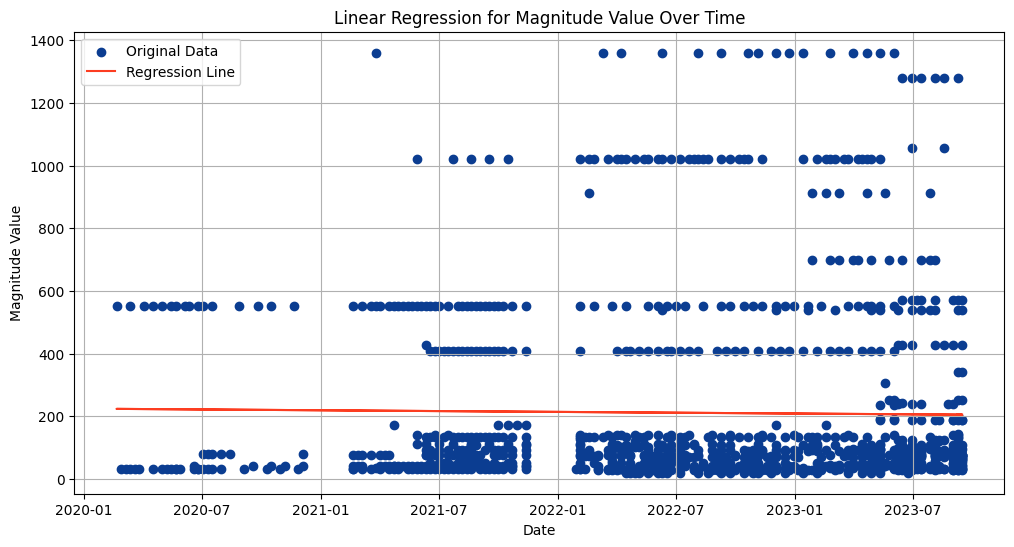

In [26]:
# The code here has some redundant variables and it should be deleted

# Convert 'Date' column to datetime
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])

# Filter data for the date range from January 2020 to September 2023
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2023-09-30')
filtered_df = filtered_df[(filtered_df['Date'] >= start_date) & (filtered_df['Date'] <= end_date)]

# Remove rows with missing Magnitude Value
filtered_df_drop = filtered_df.dropna(subset=['Magnitude Value'])

# Extract numeric features for regression
X = filtered_df_drop['Date'].apply(lambda x: x.toordinal()).values.reshape(-1, 1)
y = filtered_df_drop['Magnitude Value'].values

# Fit a linear regression model and predict values using the regression model
regression_model = LinearRegression()
regression_model.fit(X, y)
y_pred = regression_model.predict(X)

plt.figure(figsize=(12, 6))
plt.scatter(filtered_df['Date'], y, color='#0B3D91', label='Original Data')
plt.plot(filtered_df['Date'], y_pred, color='#FC3D21', label='Regression Line')
plt.xlabel('Date')
plt.ylabel('Magnitude Value')
plt.title('Linear Regression for Magnitude Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

#  Result - there is no relationship between Date and Magnitude Value. 
# This linear regression model can't be used for analysis purposes.

# EONET: Categorical model - Decision Tree

In [19]:
# Loading the dataset and define the target variable and feature columns
data = df
target_column = 'Category ID'
feature_columns = ['Longitude', 'Latitude']

# Select the relevant columns and drop rows with missing values
data = data[[*feature_columns, target_column]]
data = data.dropna()

# Encode the target variable 
label_encoder = LabelEncoder()
data[target_column] = label_encoder.fit_transform(data[target_column])

# Separate features (X) and target (y)
X = data[feature_columns]
y = data[target_column]

# Split the data into training and testing sets (80% train, 20% test) and train a Decision Tree classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Convert target_names to a list of strings
target_names = [str(label) for label in label_encoder.classes_]

# Print a classification report
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)

# Model has achieved high accuracy and good precision.
# It performs very well for the categories "seaLakeIce" "severeStorms" and "volcanoes", with both high precision.
# Precision for "wildfires" is also very high and can be used to make predictions
# Overall accuracy of the model is 99%

Accuracy: 0.9947089947089947
              precision    recall  f1-score   support

  seaLakeIce       1.00      1.00      1.00       271
severeStorms       1.00      1.00      1.00        33
   volcanoes       0.82      1.00      0.90         9
   wildfires       1.00      0.97      0.98        65

    accuracy                           0.99       378
   macro avg       0.95      0.99      0.97       378
weighted avg       1.00      0.99      0.99       378



In [20]:
# Creating a DataFrame with predicted categories and coordinates
predicted_df = pd.DataFrame({'Predicted Category': label_encoder.inverse_transform(y_pred)})
predicted_df[['Latitude', 'Longitude']] = X_test.values

,Predicted Category,Latitude,Longitude
0,seaLakeIce,57.37,-65.95
1,seaLakeIce,-50.28,-75.93
2,seaLakeIce,-52.27,-66.82
3,seaLakeIce,-54.00,-66.00
4,seaLakeIce,-31.92,-72.95


In [21]:
predicted_df.head()

,Predicted Category,Latitude,Longitude
0,seaLakeIce,57.37,-65.95
1,seaLakeIce,-50.28,-75.93
2,seaLakeIce,-52.27,-66.82
3,seaLakeIce,-54.00,-66.00
4,seaLakeIce,-31.92,-72.95


# EONET: Map of predicted values

In [41]:
# Create a map centered at an initial location
m = folium.Map(location=[predicted_df['Latitude'].iloc[0], predicted_df['Longitude'].iloc[0]], zoom_start=5)

# Define a color mapping for categories
category_colors = {
    'wildfires': 'red',
    'seaLakeIce': 'blue',
    'severeStorms': 'green',  # Add more colors as needed
}

# Iterate through the DataFrame to add markers for each prediction
for _, row in predicted_df.iterrows():
    category = row['Predicted Category']
    color = category_colors.get(category, 'orange')  
    folium.Marker(
        [row['Longitude'], row['Latitude']],
        tooltip=row['Predicted Category'],
        icon=folium.Icon(color=color),
    ).add_to(m)


m.save('Predicted_events_map.html')  

In [137]:
# Examining the results of linear regression and decision tree, it can be concluded
# that decision tree is a more suitable way to make predictions as model predictions is with much higher precision. 

# Meteorite Landings: Exploratory Data Analysis

In [22]:
# Counts of meteorite categories
category_counts = meteor['recclass'].value_counts()
filtered_cats = category_counts[category_counts >= 100]
filtered_cats

recclass
L6                 7543
H5                 6273
H6                 3903
H4                 3892
L5                 3298
LL5                2202
LL6                1660
L4                  972
H4/5                395
CM2                 332
H3                  314
CO3                 308
Iron, IIIAB         276
L3                  270
LL                  223
Ureilite            214
E3                  205
LL4                 198
CV3                 185
Howardite           179
Diogenite           178
Eucrite-pmict       169
H5/6                166
Eucrite             117
CR2                 116
Iron, IIAB          114
Mesosiderite        109
H~5                 106
Iron, ungrouped     105
Name: count, dtype: int64

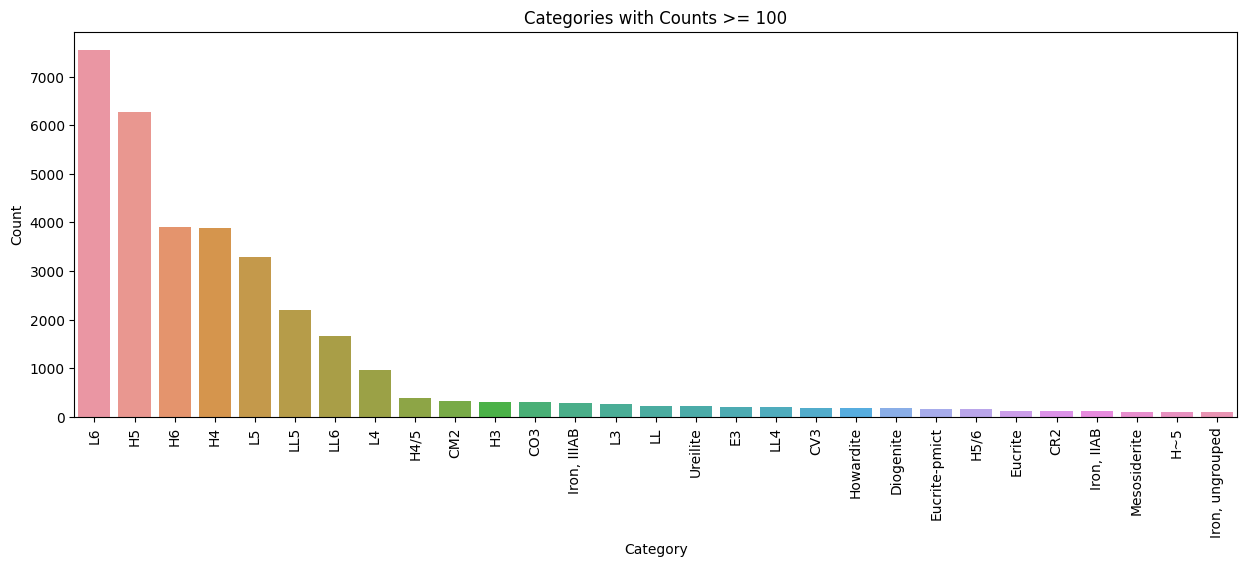

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x=filtered_cats.index, y=filtered_cats.values)
plt.title('Categories with Counts >= 100')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

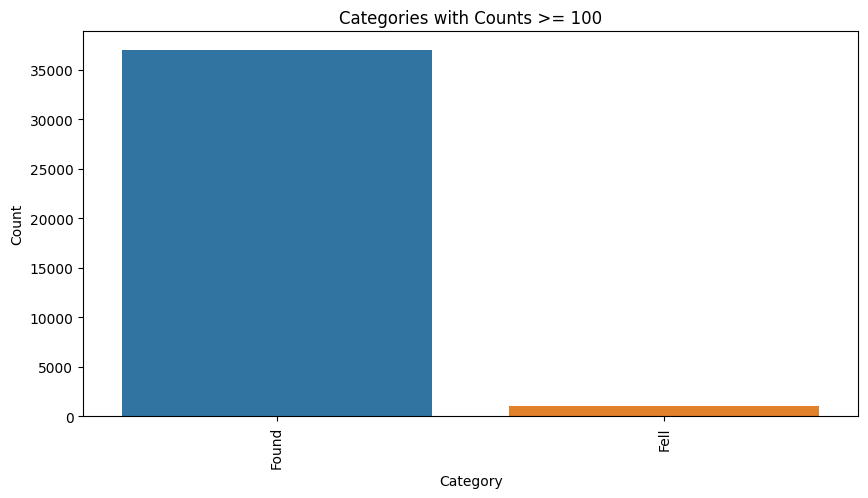

In [80]:
# Basically they are either found (found) or not found (fell)

filtered_catss = meteor['fall'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=filtered_catss.index, y=filtered_catss.values)
plt.title('Fall categories')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

In [24]:
df_geo = gpd.GeoDataFrame(meteor, geometry = gpd.points_from_xy(meteor.reclong, meteor.reclat))

In [25]:
world_data = gpd.read_file('ne_10m_admin_0_countries.shp')

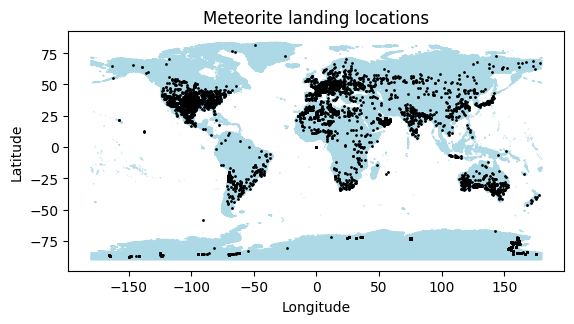

In [26]:
axis = world_data.plot(color = 'lightblue', edgecolor = 'lightblue')

df_geo.plot(ax = axis, color = 'black', markersize=1)
plt.title('Meteorite landing locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

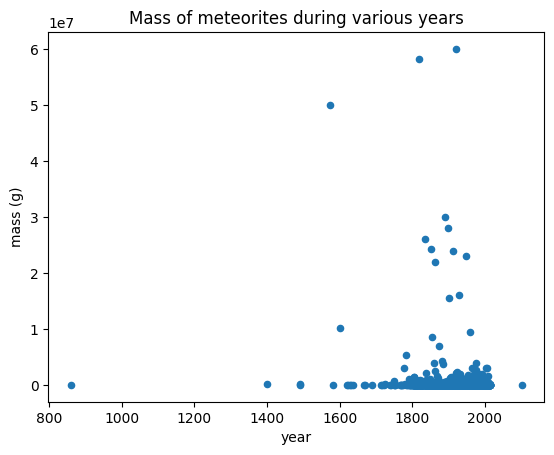

In [27]:
meteor.plot('year', 'mass (g)', kind = 'scatter')
plt.title("Mass of meteorites during various years")
plt.show()

In [66]:
category_counts = meteor['recclass'].value_counts()
filtered_cats = category_counts[category_counts >= 200]
cat_df = meteor[meteor['recclass'].isin(filtered_cats.index)]

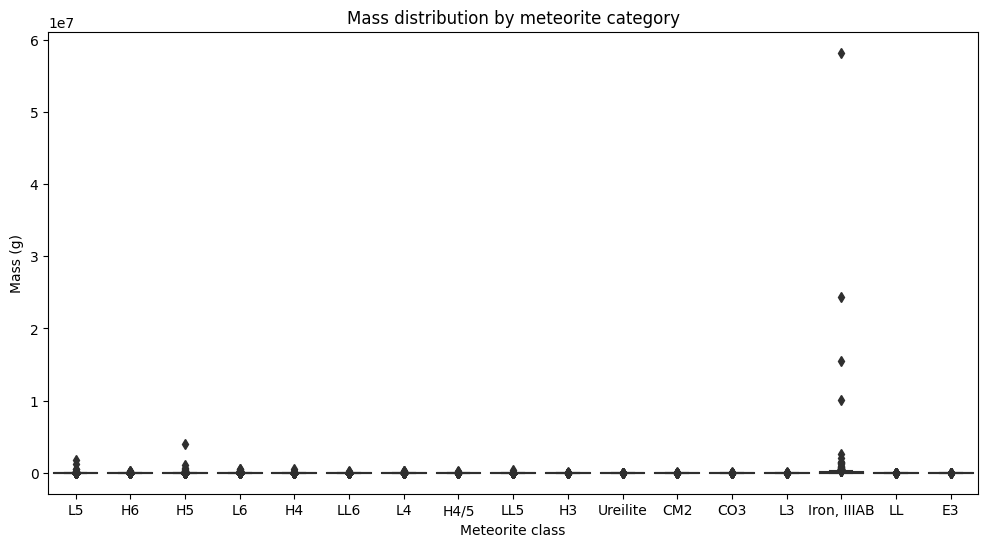

In [65]:

plt.figure(figsize=(12, 6))
sns.boxplot(x=cat_df['recclass'], y=cat_df['mass (g)'], color='#0B3D91')
plt.xlabel('Meteorite class')
plt.ylabel('Mass (g)')
plt.title('Mass distribution by meteorite category')
plt.show()

In [68]:
meteor = meteor.dropna()

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333
2,Abajo,4,Valid,H5,331.0,Found,1982.0,26.80000,-105.41667
3,Abbott,5,Valid,H3-6,21100.0,Found,1951.0,36.30000,-104.28333
4,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000
...,...,...,...,...,...,...,...,...,...
45711,Mandalay Spring,57454,Valid,L6,2854.0,Found,2012.0,40.89201,-118.55319
45712,Antelope,57455,Valid,H4,754.0,Found,2012.0,40.90183,-118.54465
45713,Northwest Africa 7870,57456,Valid,L4,42.0,Found,2004.0,0.00000,0.00000
45714,Northwest Africa 7871,57457,Valid,L6,450.0,Found,2004.0,0.00000,0.00000


In [70]:
meteor['year'] = meteor['year'].astype('int')

/tmp/ipykernel_9928/626170082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteor['year'] = meteor['year'].astype('int')


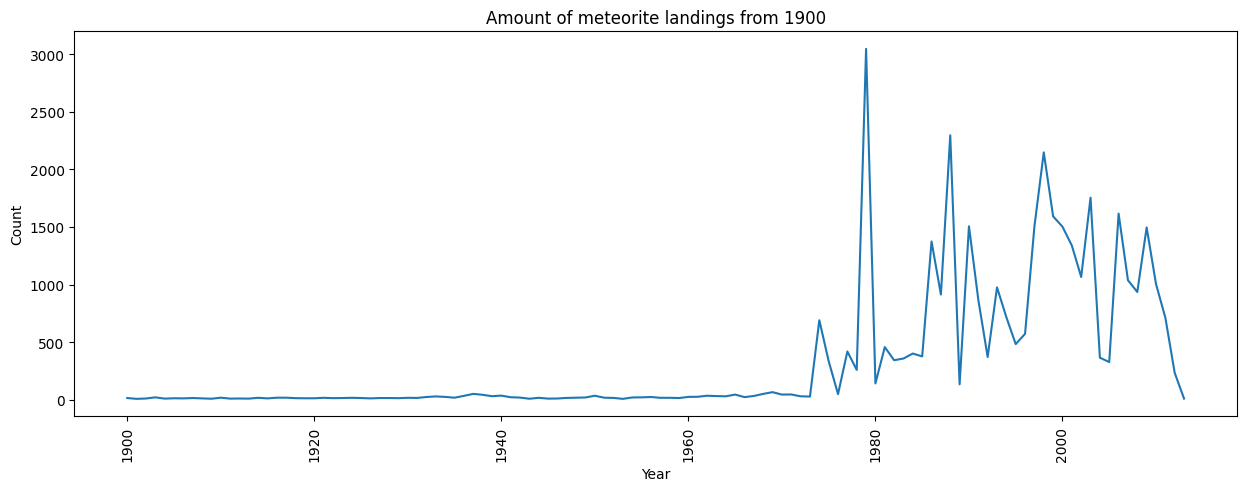

In [79]:
year_counts = meteor['year'].value_counts()
filt_years = year_counts[(year_counts.index > 1899) & (year_counts.index < 2024)]
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=filt_years.index, y=filt_years.values)
plt.title('Amount of meteorite landings from 1900')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

# Meteorite Landings: KNN model fitting on 5 most common meteorite classes

In [28]:
meteorite_categories = ['L6', 'H5', 'H6', 'H4', 'L5']
knn_df = meteor[meteor['recclass'].isin(meteorite_categories)]

In [29]:
knn_df = knn_df.drop(['name', 'id', 'nametype', 'fall'], axis=1)

In [30]:
#preparing categorical analysis for ML
cat_dict= {'L6': 0, 'H5': 1, 'H6': 2, 'H4': 3, 'L5':4}
knn_df['recclass'] = knn_df['recclass'].replace(cat_dict)
knn_df = knn_df.dropna()

In [31]:
X = knn_df.drop(['recclass'], axis=1)
y = knn_df['recclass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 5, stratify = y)

In [32]:
#determining number of neighbors (K)
neighbors = []
knn_scores = []
for i in range(3, 100):
    knn= KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    a = knn.score(X_test, y_test)
    neighbors.append(i)
    knn_scores.append(a)

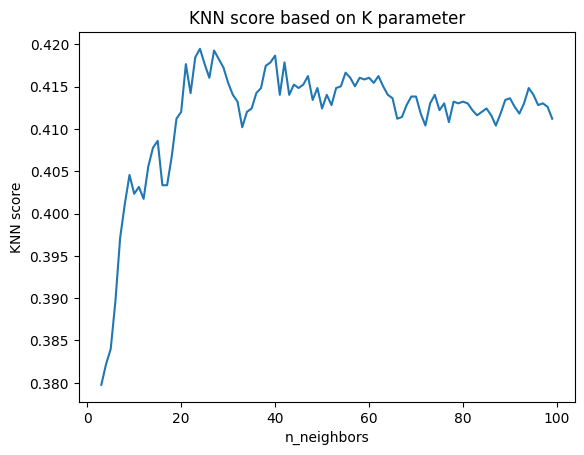

In [33]:
plt.plot(neighbors, knn_scores)
plt.title("KNN score based on K parameter")
plt.xlabel("n_neighbors")
plt.ylabel("KNN score")
plt.show()

In [34]:
index = knn_scores.index(max(knn_scores))
index 

21

In [35]:
leafs = []
knn_sc = []
for i in range(10, 100):
    knn= KNeighborsClassifier(n_neighbors=21, leaf_size=i)
    knn.fit(X_train, y_train)
    a = knn.score(X_test, y_test)
    leafs.append(i)
    knn_sc.append(a)


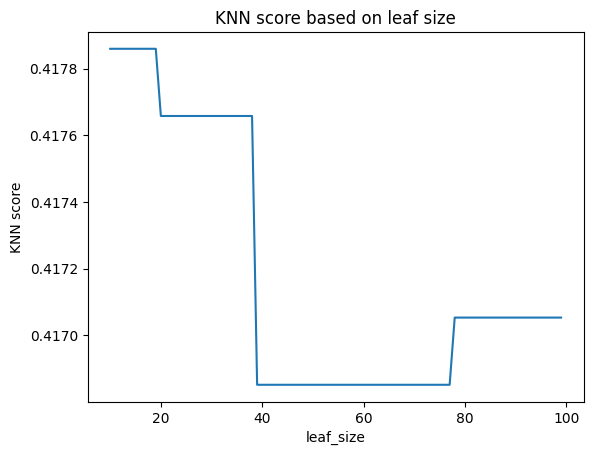

In [36]:
plt.plot(leafs, knn_sc)
plt.title("KNN score based on leaf size")
plt.xlabel("leaf_size")
plt.ylabel("KNN score")
plt.show()

# EONET: Event Count from January 2019 - September 2023

/tmp/ipykernel_9928/3694118327.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])


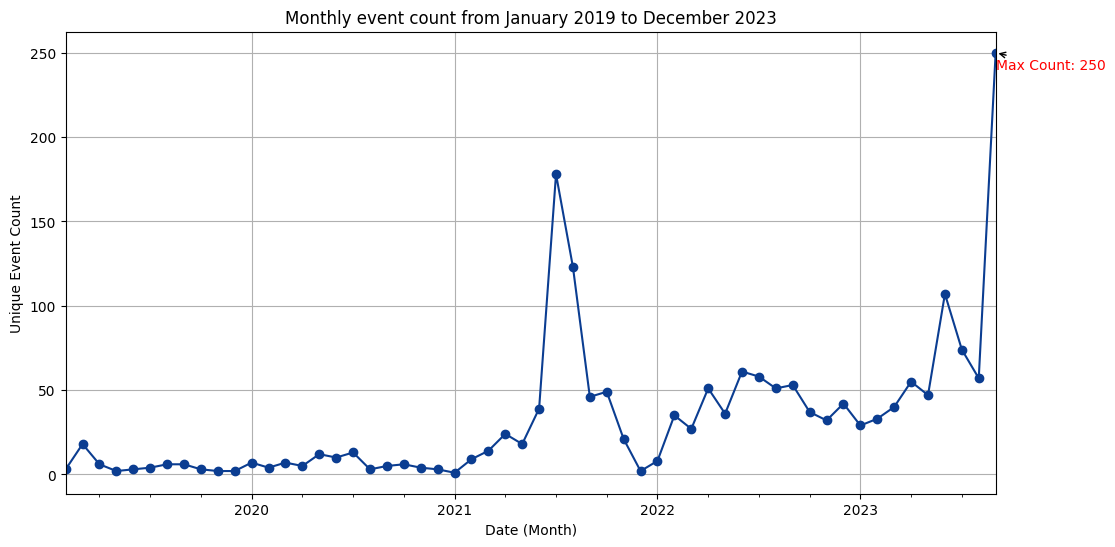

Month with maximum event count: 2023-09
Maximum event count: 250


In [37]:
# Filter data for the date range from January 2019 to September 2023 and convert the 'Date' column to datetime format
start_date = '2019-01-01'
end_date = '2023-09-20'

filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])

# Group data by month and count the number of events for each month
event_counts = filtered_df.groupby(filtered_df['Date'].dt.to_period('M'))['id'].count()

plt.figure(figsize=(12, 6))
event_counts.plot(marker='o', linestyle='-', color='#0B3D91')
plt.xlabel('Date (Month)')
plt.ylabel('Unique Event Count')
plt.title('Monthly event count from January 2019 to December 2023')
plt.grid(True)

# Find the date with the maximum event count and format max_count_date to display only year and month
max_count_date = event_counts.idxmax()
max_event_count = event_counts.max()
max_count_date_formatted = max_count_date.strftime('%Y-%m')

plt.annotate(f'Max Count: {max_event_count}', xy=(max_count_date, max_event_count), color='red', xytext=(max_count_date, max_event_count - 10), arrowprops=dict(arrowstyle='->'))
plt.show()

print(f"Month with maximum event count: {max_count_date}")
print(f"Maximum event count: {max_event_count}")


# EONET: Daily Event Count from May 2021 to September 2023

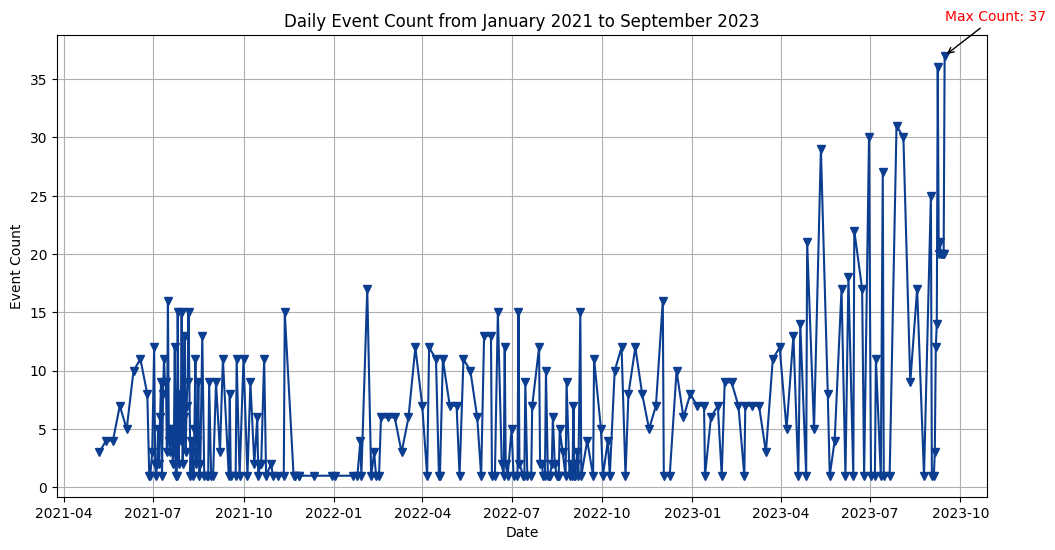

Date with Maximum Event Count: 2023-09-15
Maximum Event Count: 37


In [39]:
# Filter data for the date range from January 2021 to September 2023
start_date_str = '2021-05-01'
end_date_str = '2023-09-30'
df['Date'] = pd.to_datetime(df['Date'])

# Convert start_date_str and end_date_str to datetime objects
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

# Filter data for the date range from January 2021 to September 2023
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Group data by date and count the number of events for each date
event_counts = filtered_df.groupby(filtered_df['Date'].dt.date)['id'].count()

plt.figure(figsize=(12, 6))
event_counts.plot(marker='v', linestyle='-', color='#0B3D91')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.title('Daily Event Count from January 2021 to September 2023')
plt.grid(True)

# Find the date with the maximum event count
max_count_date = event_counts.idxmax()
max_event_count = event_counts.max()

plt.annotate(f'Max Count: {max_event_count}', xy=(max_count_date, max_event_count), color='red', xytext=(max_count_date, max_event_count + 3), arrowprops=dict(arrowstyle='->'))
plt.show()

print(f"Date with Maximum Event Count: {max_count_date}")
print(f"Maximum Event Count: {max_event_count}")


# EONET: Distribution of Events by hour of the Day

In [42]:
# Next cell gave an error because time column has 'Z' in the end (using csv). You can delete this cell later
import re
def date_reformat(date):
    pattern = r'^(\d{2}:\d{2}:\d{2})'
    match = re.search(pattern, date)
    if match:
        return match.group(1)
    else:
        return None
    
df['Time'] = df['Time'].apply(date_reformat)

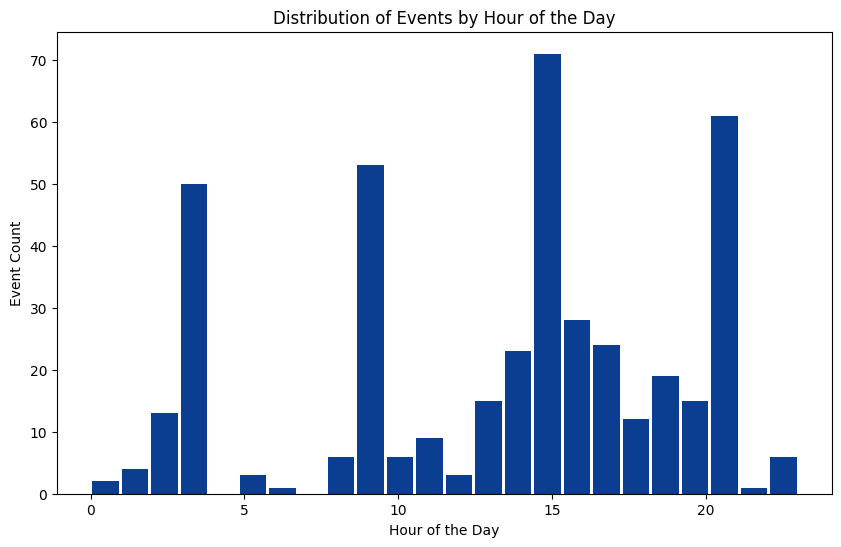

In [46]:
# Convert the 'Time' column to datetime objects
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

# Filter out events with a time of 00:00:00 
filtered_df = df.loc[df['Time'].dt.time != pd.to_datetime('00:00:00').time()]

plt.figure(figsize=(10, 6))
filtered_df['Time'].dt.hour.plot(kind='hist', bins=24, rwidth=0.9, color='#0B3D91')
plt.xlabel('Hour of the Day')
plt.ylabel('Event Count')
plt.title('Distribution of Events by Hour of the Day')
plt.show()

# EONET: Event count distribution by hour and minute (excluding midnight)

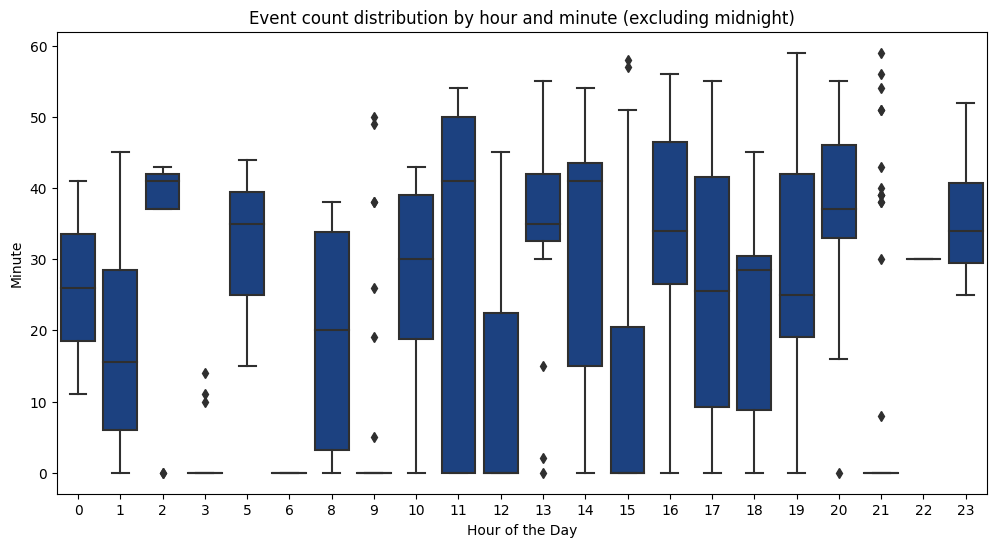

In [47]:
# Filter out events with a time of 00:00:00
filtered_df = df[df['Time'].dt.time != pd.to_datetime('00:00:00').time()]

plt.figure(figsize=(12, 6))
sns.boxplot(x=filtered_df['Time'].dt.hour, y=filtered_df['Time'].dt.minute, color='#0B3D91')
plt.xlabel('Hour of the Day')
plt.ylabel('Minute')
plt.title('Event count distribution by hour and minute (excluding midnight)')
plt.show()


# EONET: Count of Events by categories

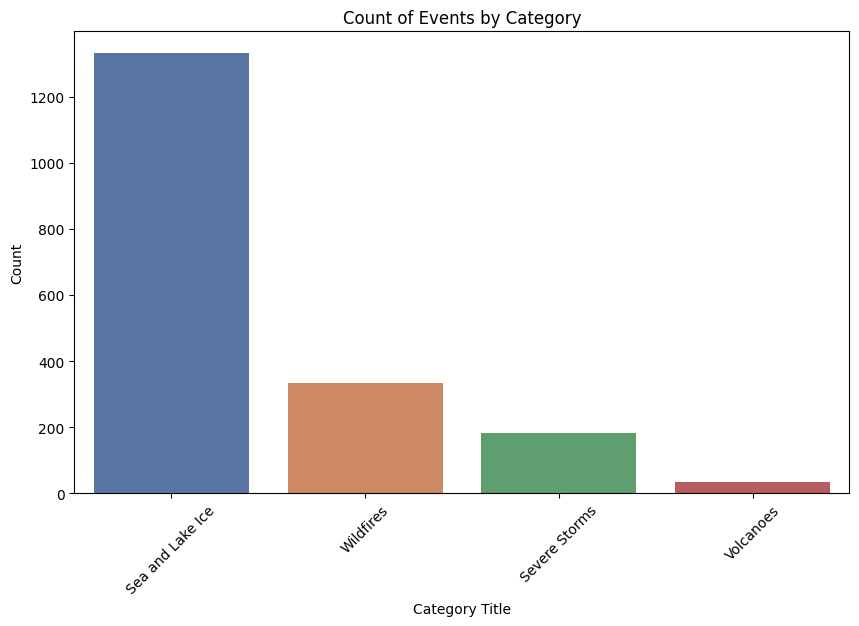

In [48]:
category_counts = df['Category Title'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='deep')
plt.xlabel('Category Title')
plt.ylabel('Count')
plt.title('Count of Events by Category')
plt.xticks(rotation=45)
plt.show()

# EONET: Event Count Over Years by Category

/tmp/ipykernel_9928/4161779964.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.dropna(subset=['Date'], inplace=True)
/tmp/ipykernel_9928/4161779964.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = filtered_df['Date'].dt.year


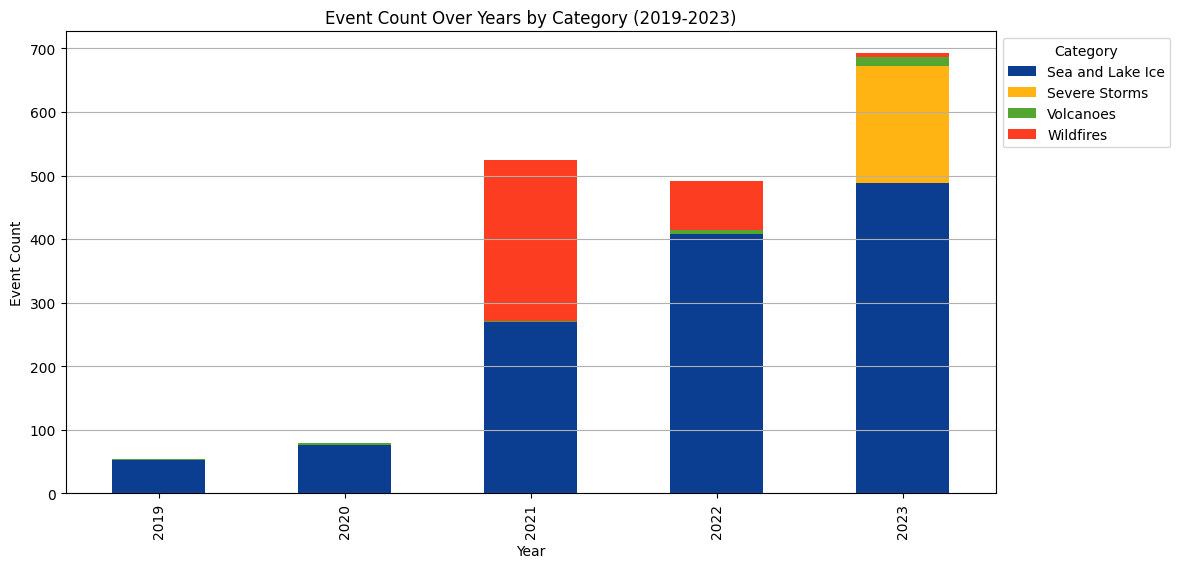

In [49]:
# Convert 'date_only' to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Filter the DataFrame for period January 2019 - September 2023
start_date = '2019-01-01'
end_date = '2023-09-30'  
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

category_colors = ['#0B3D91', '#FFB414', '#55A630', '#FC3D21']

# Drop rows with missing or invalid dates and extract year from the 'Date' column
filtered_df.dropna(subset=['Date'], inplace=True)

filtered_df['Year'] = filtered_df['Date'].dt.year

# Group events by category and year and count events
category_counts = filtered_df.groupby(['Year', 'Category Title']).size().unstack(fill_value=0)

category_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=category_colors)
plt.xlabel('Year')
plt.ylabel('Event Count')
plt.title('Event Count Over Years by Category (2019-2023)')
plt.legend(title='Category', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y')
plt.show()


# EONET: Events frequency sorted by magnitude values

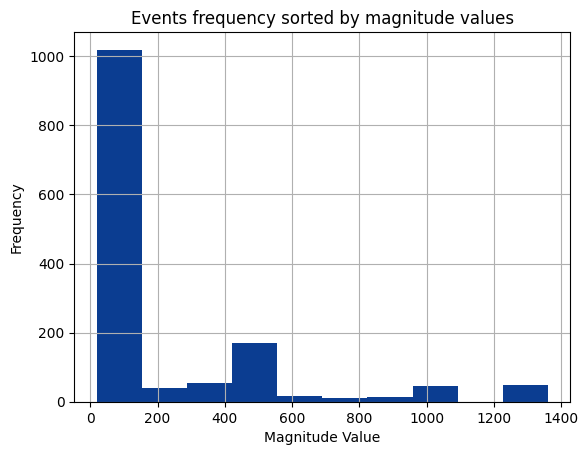

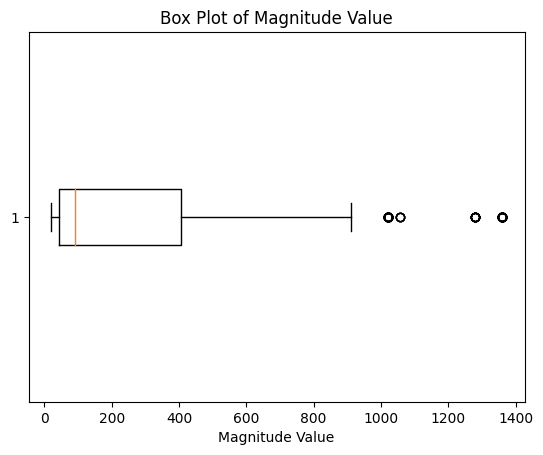

In [50]:
# Remove rows with NaN values from the column
filtered_data = df['Magnitude Value'].dropna()

# Histogram
filtered_data.hist(color='#0B3D91')
plt.xlabel('Magnitude Value')
plt.ylabel('Frequency')
plt.title('Events frequency sorted by magnitude values')

# Box plot
plt.figure()
plt.boxplot(filtered_data, vert=False)
plt.xlabel('Magnitude Value')
plt.title('Box Plot of Magnitude Value')
plt.show()


# EONET: Event Distribution by Source

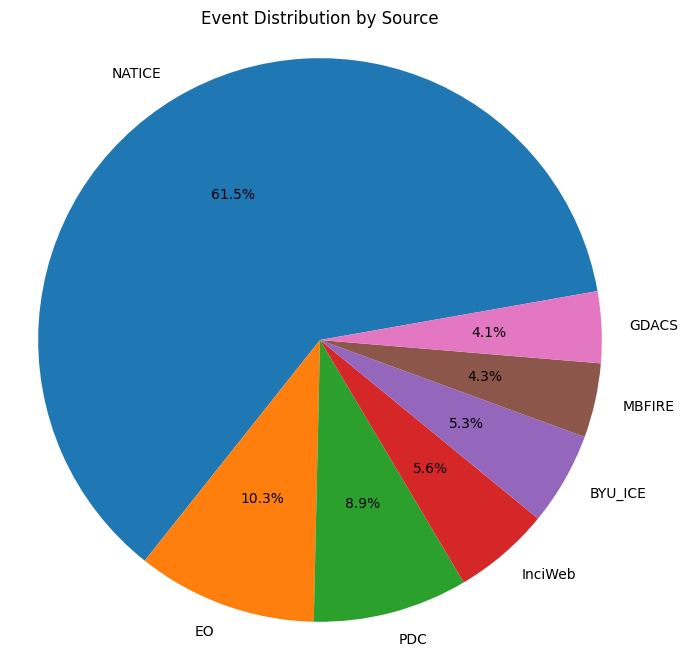

In [52]:
# Group events by source and date and count events
source_counts = df.groupby(['Date', 'Source ID']).size().unstack(fill_value=0)

# Sum the event counts for each source over the entire time period
total_event_counts = source_counts.sum()

# Include 7 largest values
total_event_counts = total_event_counts.nlargest(7)


plt.figure(figsize=(8, 8))
plt.pie(total_event_counts, labels=total_event_counts.index, autopct='%1.1f%%', startangle=10)
plt.title('Event Distribution by Source')
plt.axis('equal')  

plt.show()

# EONET: Map centered at a specific location by category

In [53]:
# Create a map centered at a specific location and set the categories
m = folium.Map(location=[0, 0], zoom_start=2)  

category_colors = {
    'wildfires': 'red',
    'seaLakeIce': 'blue', 
    'severeStorms': 'green', 
   
}

# Iterate through the DataFrame and add colors to each event
for index, row in df.iterrows():
    category = row['Category ID']
    if category in category_colors:
        color = category_colors[category]
    else:
        color = 'orange' 

    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['title'],
        icon=folium.Icon(color=color)
    ).add_to(m)

# Save the map
m.save('event_map_colored.html')  

# EONET: Countries and Event Counts 

In [98]:
# Load the world map dataset and create a GeoDataFrame from the DataFrame with event coordinates
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Longitude'], df['Latitude'])
)

# Set the CRS of gdf to match the CRS of world
gdf.crs = world.crs

# Perform a spatial join to associate events with countries
events_with_country = gpd.sjoin(gdf, world, how='inner', op='intersects')

# Count the number of events within each country
event_counts = events_with_country['name'].value_counts().reset_index()
event_counts.columns = ['Country', 'Event Count']

print("Countries and Event Counts:")
print(event_counts)

/tmp/ipykernel_9928/4225845322.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/home/ievapociute/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Countries and Event Counts:
                     Country  Event Count
0   United States of America          187
1                     Canada           97
2                      Italy           14
3                  Guatemala            8
4                      Spain            8
5                     Greece            5
6                     France            5
7                   Portugal            3
8                     Turkey            3
9                 Montenegro            3
10                Antarctica            3
11                 Indonesia            3
12                      Peru            3
13                    Russia            3
14                   Algeria            2
15                   Ecuador            2
16           North Macedonia            1
17          Papua New Guinea            1
18                 Argentina            1
19                   Tunisia            1
20                   Lebanon            1
21                   Albania            1
22    

# EONET: Wordcloud of event's title

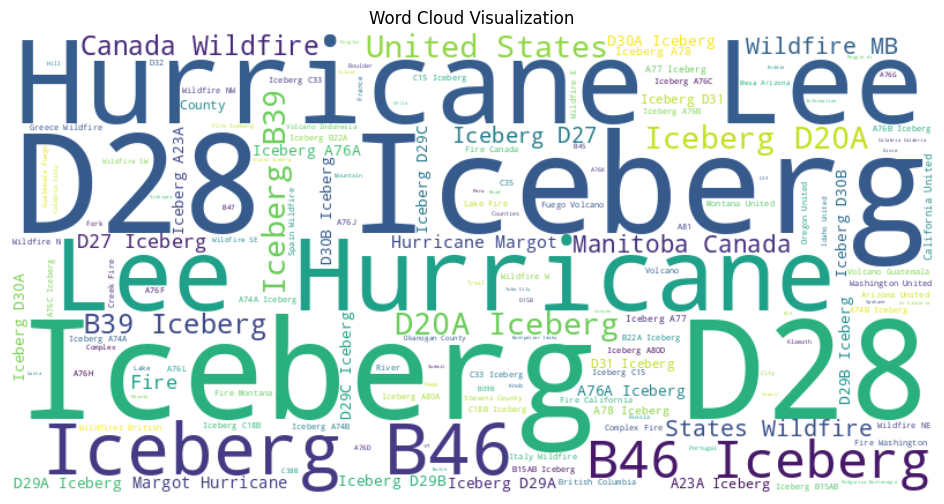

In [55]:
text_data = df['title'].str.cat(sep=' ')

# Generate a word cloud from the events title
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Visualization')
plt.show()


# NASA images: Earth planet image by date

In [13]:
base_url = 'https://api.nasa.gov/EPIC/api/natural'
api_key = 'your_key'
date = '2023-09-16'

In [14]:
request_url = f'{base_url}/{date}?api_key={api_key}'

# Make the API request
response = requests.get(request_url)
    
if response.status_code == 200:
    # Parse the JSON response to get the image URL
    data = response.json()
    img_date = data[0]['date']
    formatted_date = datetime.strptime(img_date, '%Y-%m-%d %H:%M:%S').strftime('%Y/%m/%d')
    epic_url = 'https://epic.gsfc.nasa.gov/archive/natural/'
    img_name = data[0]['image']
    image_url = f'{epic_url}{formatted_date}/png/{img_name}.png'
        
    # display the image
    display(Image(url=image_url))

# Combination of EONET and Meteorite Landings: what kind of events happened in USA?

In [97]:
meteor

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong
0,Aachen,1,Valid,L5,21.0,Fell,1880,50.77500,6.08333
1,Aarhus,2,Valid,H6,720.0,Fell,1951,56.18333,10.23333
2,Abajo,4,Valid,H5,331.0,Found,1982,26.80000,-105.41667
3,Abbott,5,Valid,H3-6,21100.0,Found,1951,36.30000,-104.28333
4,Abee,6,Valid,EH4,107000.0,Fell,1952,54.21667,-113.00000
...,...,...,...,...,...,...,...,...,...
45711,Mandalay Spring,57454,Valid,L6,2854.0,Found,2012,40.89201,-118.55319
45712,Antelope,57455,Valid,H4,754.0,Found,2012,40.90183,-118.54465
45713,Northwest Africa 7870,57456,Valid,L4,42.0,Found,2004,0.00000,0.00000
45714,Northwest Africa 7871,57457,Valid,L6,450.0,Found,2004,0.00000,0.00000


In [99]:
df

,_id,id,link,title,Category ID,Category Title,Magnitude Value,Magnitude Unit,Geometry Type,Source ID,Source URL,Date,Time,Longitude,Latitude
0,Row(oid='6506a0255457d4ab94009af1'),EONET_6425,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,"Kilauea Volcano, Hawaii",volcanoes,Volcanoes,NaN,NaN,Point,SIVolcano,https://volcano.si.edu/volcano.cfm?vn=332010,2023-09-10,1900-01-01,-155.287,19.421
1,Row(oid='6506a0255457d4ab94009af2'),EONET_6423,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg D33A,seaLakeIce,Sea and Lake Ice,340.0,NM^2,Point,NATICE,https://usicecenter.gov/pub/Iceberg_Tabular.csv,2023-09-08,1900-01-01,17.140,-69.380
2,Row(oid='6506a0255457d4ab94009af2'),EONET_6423,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg D33A,seaLakeIce,Sea and Lake Ice,340.0,NM^2,Point,NATICE,https://usicecenter.gov/pub/Iceberg_Tabular.csv,2023-09-15,1900-01-01,14.370,-69.230
3,Row(oid='6506a0255457d4ab94009af3'),EONET_6424,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg D33B,seaLakeIce,Sea and Lake Ice,252.0,NM^2,Point,NATICE,https://usicecenter.gov/pub/Iceberg_Tabular.csv,2023-09-08,1900-01-01,18.300,-69.640
4,Row(oid='6506a0255457d4ab94009af3'),EONET_6424,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg D33B,seaLakeIce,Sea and Lake Ice,252.0,NM^2,Point,NATICE,https://usicecenter.gov/pub/Iceberg_Tabular.csv,2023-09-15,1900-01-01,16.600,-69.450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,Row(oid='6506a0255457d4ab94009c8c'),EONET_980,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,"Fuego Volcano, Guatemala",volcanoes,Volcanoes,NaN,NaN,Point,GDACS,http://www.gdacs.org/report.aspx?eventtype=VO&...,2002-01-04,1900-01-01,-90.880,14.473
1882,Row(oid='6506a0255457d4ab94009c8c'),EONET_980,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,"Fuego Volcano, Guatemala",volcanoes,Volcanoes,NaN,NaN,Point,IDC,https://disasterscharter.org/web/guest/-/volca...,2002-01-04,1900-01-01,-90.880,14.473
1883,Row(oid='6506a0255457d4ab94009c8c'),EONET_980,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,"Fuego Volcano, Guatemala",volcanoes,Volcanoes,NaN,NaN,Point,NASA_DISP,https://disasters.nasa.gov/mount-fuego-eruptio...,2002-01-04,1900-01-01,-90.880,14.473
1884,Row(oid='6506a0255457d4ab94009c8c'),EONET_980,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,"Fuego Volcano, Guatemala",volcanoes,Volcanoes,NaN,NaN,Point,ReliefWeb,https://reliefweb.int/disaster/vo-2018-000066-gtm,2002-01-04,1900-01-01,-90.880,14.473


In [101]:
nasa_merged = meteor.merge(df, left_on = ['reclat', 'reclong'], right_on = ['Latitude', 'Longitude'])
nasa_merged

,name,id_x,nametype,recclass,mass (g),fall,year,reclat,reclong,_id,...,Category Title,Magnitude Value,Magnitude Unit,Geometry Type,Source ID,Source URL,Date,Time,Longitude,Latitude


In [110]:
meteor.rename(columns={'name': 'meteorite_name', 'reclong': 'Longitude', 'reclat':'Latitude', 'year':'Date'}, inplace=True)


In [113]:
# It was easier for me like that, because using dt.year for 'Date' column returns all values as 1970
def date_reformat(date):
    pattern = r'^(\d{4})'
    match = re.search(pattern, date)
    if match:
        return match.group(1)
    else:
        return None
    
df['Date'] = df['Date'].apply(date_reformat)
df['Date'] = df['Date'].astype('int')

In [114]:
merged_df = pd.merge(df, meteor, on=['Longitude', 'Latitude', 'Date'], how='outer')
merged_df

,_id,id_x,link,title,Category ID,Category Title,Magnitude Value,Magnitude Unit,Geometry Type,Source ID,...,Date,Time,Longitude,Latitude,meteorite_name,id_y,nametype,recclass,mass (g),fall
0,Row(oid='6506a0255457d4ab94009af1'),EONET_6425,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,"Kilauea Volcano, Hawaii",volcanoes,Volcanoes,NaN,NaN,Point,SIVolcano,...,2023,00:00:00Z,-155.28700,19.42100,NaN,NaN,NaN,NaN,NaN,NaN
1,Row(oid='6506a0255457d4ab94009af2'),EONET_6423,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg D33A,seaLakeIce,Sea and Lake Ice,340.0,NM^2,Point,NATICE,...,2023,00:00:00Z,17.14000,-69.38000,NaN,NaN,NaN,NaN,NaN,NaN
2,Row(oid='6506a0255457d4ab94009af2'),EONET_6423,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg D33A,seaLakeIce,Sea and Lake Ice,340.0,NM^2,Point,NATICE,...,2023,00:00:00Z,14.37000,-69.23000,NaN,NaN,NaN,NaN,NaN,NaN
3,Row(oid='6506a0255457d4ab94009af3'),EONET_6424,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg D33B,seaLakeIce,Sea and Lake Ice,252.0,NM^2,Point,NATICE,...,2023,00:00:00Z,18.30000,-69.64000,NaN,NaN,NaN,NaN,NaN,NaN
4,Row(oid='6506a0255457d4ab94009af3'),EONET_6424,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg D33B,seaLakeIce,Sea and Lake Ice,252.0,NM^2,Point,NATICE,...,2023,00:00:00Z,16.60000,-69.45000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2011,NaN,54.88668,19.15823,Dhofar 1733,57433.0,Valid,L3,7700.0,Found
39997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2012,NaN,-118.14640,34.82793,Rosamond,57434.0,Valid,LL3,11.1,Found
39998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2011,NaN,-118.49693,40.95465,Smokey Spring,57453.0,Valid,H4,254.0,Found
39999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2012,NaN,-118.55319,40.89201,Mandalay Spring,57454.0,Valid,L6,2854.0,Found


OK, I struggle to make the merged dataframe to geopandas. It does not work to merge 2 geopandas datasets (they merge, but in a wrong way)

In [117]:
# Load the world map dataset and create a GeoDataFrame from the DataFrame with event coordinates
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf_all = gpd.GeoDataFrame(
    merged_df,
    geometry=gpd.points_from_xy(merged_df['Longitude'], merged_df['Latitude'])
)

# Set the CRS of gdf to match the CRS of world
gdf_all.crs = world.crs

# Perform a spatial join to associate events with countries
events_with_country_all = gpd.sjoin(gdf_all, world, how='inner', op='intersects')

# Count the number of events within each country
event_counts = events_with_country['name'].value_counts().reset_index()
events_with_country

/tmp/ipykernel_9928/1134644603.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/home/ievapociute/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,_id,id,link,title,Category ID,Category Title,Magnitude Value,Magnitude Unit,Geometry Type,Source ID,...,Time,Longitude,Latitude,geometry,index_right,pop_est,continent,name,iso_a3,gdp_md_est
0,Row(oid='6506a0255457d4ab94009af1'),EONET_6425,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,"Kilauea Volcano, Hawaii",volcanoes,Volcanoes,NaN,NaN,Point,SIVolcano,...,1900-01-01 00:00:00,-155.2870,19.4210,POINT (-155.28700 19.42100),4,328239523.0,North America,United States of America,USA,21433226
189,Row(oid='6506a0255457d4ab94009af6'),EONET_6418,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Peacock Fire Information,wildfires,Wildfires,NaN,NaN,Point,InciWeb,...,1900-01-01 21:08:00,-100.3936,33.2128,POINT (-100.39360 33.21280),4,328239523.0,North America,United States of America,USA,21433226
191,Row(oid='6506a0255457d4ab94009af8'),EONET_6402,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Wanes Gray Fire Information,wildfires,Wildfires,NaN,NaN,Point,InciWeb,...,1900-01-01 16:27:00,-117.7311,47.5400,POINT (-117.73110 47.54000),4,328239523.0,North America,United States of America,USA,21433226
192,Row(oid='6506a0255457d4ab94009af9'),EONET_6388,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Flat Fire Information,wildfires,Wildfires,NaN,NaN,Point,InciWeb,...,1900-01-01 21:51:00,-124.0372,42.5158,POINT (-124.03720 42.51580),4,328239523.0,North America,United States of America,USA,21433226
193,Row(oid='6506a0255457d4ab94009afa'),EONET_6393,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,"Shishaldin Volcano, Alaska",volcanoes,Volcanoes,NaN,NaN,Point,EO,...,1900-01-01 00:00:00,-163.9700,65.7560,POINT (-163.97000 65.75600),4,328239523.0,North America,United States of America,USA,21433226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,Row(oid='6506a0255457d4ab94009c70'),EONET_4269,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,"Reventador Volcano, Ecuador",volcanoes,Volcanoes,NaN,NaN,Point,SIVolcano,...,1900-01-01 00:00:00,-77.6500,-0.0700,POINT (-77.65000 -0.07000),44,17373662.0,South America,Ecuador,ECU,107435
1335,Row(oid='6506a0255457d4ab94009c71'),EONET_4156,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,"Sangay Volcano, Ecuador",volcanoes,Volcanoes,NaN,NaN,Point,SIVolcano,...,1900-01-01 09:19:10,-78.3410,-2.0050,POINT (-78.34100 -2.00500),44,17373662.0,South America,Ecuador,ECU,107435
1473,Row(oid='6506a0255457d4ab94009c7b'),EONET_4140,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg C35,seaLakeIce,Sea and Lake Ice,NaN,NaN,Point,NATICE,...,1900-01-01 00:00:00,148.2000,-68.2600,POINT (148.20000 -68.26000),159,4490.0,Antarctica,Antarctica,ATA,898
1783,Row(oid='6506a0255457d4ab94009c8a'),EONET_2879,https://eonet.gsfc.nasa.gov/api/v3/events/EONE...,Iceberg D20A,seaLakeIce,Sea and Lake Ice,NaN,NaN,Point,BYU_ICE,...,1900-01-01 00:00:00,36.9008,-69.2625,POINT (36.90080 -69.26250),159,4490.0,Antarctica,Antarctica,ATA,898
